# PM2.5 Autoregressive Model - Data Preparation & Analysis

Single clean notebook for PM2.5 forecasting with H3 spatial aggregation

## 1: Data Loading & Coverage Analysis

In [10]:
import pandas as pd
import numpy as np
import h3
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [11]:
DATA_PATH = '/Users/vojtech/Code/Bard89/Project-Data/data/processed/jp_openaq_processed_20230101_to_20231231.csv'

dtypes = {
    'h3_index_res8': 'str',
    'pm25_ugm3_mean': 'float32',
    'h3_lat_res8': 'float32',
    'h3_lon_res8': 'float32'
}

df = pd.read_csv(DATA_PATH, 
                 usecols=['timestamp'] + list(dtypes.keys()),
                 dtype=dtypes,
                 parse_dates=['timestamp'])

# Filter valid 2023 data (all the data should be good though)
df = df[(df['timestamp'] >= pd.Timestamp('2023-01-01', tz='UTC')) & 
        (df['timestamp'] <= pd.Timestamp('2023-12-31 23:59:59', tz='UTC'))]

print(f"Loaded {len(df):,} valid 2023 records")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"PM2.5 missing: {df['pm25_ugm3_mean'].isna().mean():.1%}")

Loaded 2,078,211 valid 2023 records
Date range: 2023-07-14 16:00:00+00:00 to 2023-12-31 23:00:00+00:00
PM2.5 missing: 21.2%


## 2: H3 Resolution Analysis

In [26]:
def aggregate_to_resolution(df, target_res):
    """Aggregate data from res8 to coarser resolution"""
    print(f"\nAggregating to resolution {target_res}...")
    
    # Create parent hexagon
    df_copy = df.copy()
    df_copy['h3_parent'] = df_copy['h3_index_res8'].apply(
        lambda x: h3.cell_to_parent(x, target_res) if pd.notna(x) else None
    )
    
    # Aggregate
    agg = df_copy.groupby(['timestamp', 'h3_parent']).agg({
        'pm25_ugm3_mean': 'mean',
        'h3_lat_res8': 'mean',
        'h3_lon_res8': 'mean'
    }).reset_index()
    
    # Calculate coverage
    total_hours = agg['timestamp'].nunique()
    coverage = agg.groupby('h3_parent').agg({
        'pm25_ugm3_mean': lambda x: x.notna().sum() / total_hours
    })
    
    return agg, coverage

# Test resolutions 7 (5km²), 6 (36km²), 5 (252km²)
resolutions = {}
resolution_stats = []

for res in [7, 6, 5]:
    agg_data, coverage = aggregate_to_resolution(df, res)
    
    hexagons_80pct = (coverage['pm25_ugm3_mean'] > 0.8).sum()
    mean_coverage = coverage['pm25_ugm3_mean'].mean()
    
    resolutions[res] = {
        'data': agg_data,
        'coverage': coverage,
        'hexagons_80pct': hexagons_80pct,
        'mean_coverage': mean_coverage
    }
    
    resolution_stats.append({
        'Resolution': res,
        'Area (km²)': [5.16, 36.13, 252.9][7-res],
        'Total Hexagons': agg_data['h3_parent'].nunique(),
        'Hexagons >80%': hexagons_80pct,
        'Mean Coverage': f"{mean_coverage:.1%}"
    })

print("\nResolution Comparison:")
print(pd.DataFrame(resolution_stats).to_string(index=False))

# Store globally for later use
all_sensors = df['h3_index_res8'].dropna().unique()
print(f"\nTotal unique sensors: {len(all_sensors)}")


Aggregating to resolution 7...

Aggregating to resolution 6...

Aggregating to resolution 5...

Resolution Comparison:
 Resolution  Area (km²)  Total Hexagons  Hexagons >80% Mean Coverage
          7       5.160             629            451         74.6%
          6      36.130             544            408         77.3%
          5     252.900             351            283         81.9%

Total unique sensors: 638


In [13]:
# Create combined comparison map for ALL JAPAN 2023 with sensor locations
print("\nCreating combined comparison map for all Japan 2023 data with sensor locations...")

# Calculate center coordinates from all data
all_lats = df['h3_lat_res8'].dropna()
all_lons = df['h3_lon_res8'].dropna()
center_lat = all_lats.mean()
center_lon = all_lons.mean()

print(f"Map center: {center_lat:.4f}°N, {center_lon:.4f}°E")

comparison_map = folium.Map(
    location=[center_lat, center_lon],  # Use center from all Japan data
    zoom_start=5,
    tiles='OpenStreetMap',
    control_scale=True
)

# Add measurement tool - import first
from folium.plugins import MeasureControl
comparison_map.add_child(MeasureControl(primary_length_unit='kilometers'))

# Add layer for each resolution
from folium import plugins

# Get unique sensor locations with their coordinates
sensor_locations = df[['h3_index_res8', 'h3_lat_res8', 'h3_lon_res8']].drop_duplicates()

# Original sensor points layer
sensor_layer = folium.FeatureGroup(name='📍 Original Sensor Locations', show=True)
for _, row in sensor_locations.iterrows():
    if pd.notna(row['h3_lat_res8']) and pd.notna(row['h3_lon_res8']):
        folium.CircleMarker(
            location=[row['h3_lat_res8'], row['h3_lon_res8']],
            radius=2,
            color='darkblue',
            fill=True,
            fillColor='blue',
            fillOpacity=0.8,
            weight=1,
            popup=f"Sensor Location<br>Lat: {row['h3_lat_res8']:.4f}<br>Lon: {row['h3_lon_res8']:.4f}<br>H3: {row['h3_index_res8']}",
            tooltip=f"Sensor: {row['h3_lat_res8']:.2f}°N, {row['h3_lon_res8']:.2f}°E"
        ).add_to(sensor_layer)
sensor_layer.add_to(comparison_map)

# Resolution 7 
res7_hexagons = {}
for sensor in all_sensors:  # Use all Japan sensors
    if pd.notna(sensor):
        parent = h3.cell_to_parent(sensor, 7)
        res7_hexagons[parent] = res7_hexagons.get(parent, 0) + 1

res7_layer = folium.FeatureGroup(name='Resolution 7 (5.16 km²)', show=True)
for hex_id, count in res7_hexagons.items():
    try:
        boundary = h3.cell_to_boundary(hex_id)
        # Yellow for aggregated, green for single
        color = '#00FF00' if count == 1 else '#FFFF00'
        fill_opacity = 0.3 if count == 1 else 0.5
        folium.Polygon(
            locations=boundary,
            color=color,
            weight=2,
            fill=True,
            fillColor=color,
            fillOpacity=fill_opacity,
            tooltip=f"Res 7: {count} sensors, 5.16 km²"
        ).add_to(res7_layer)
    except:
        continue
res7_layer.add_to(comparison_map)

# Resolution 6
res6_hexagons = {}
for sensor in all_sensors:
    if pd.notna(sensor):
        parent = h3.cell_to_parent(sensor, 6)
        res6_hexagons[parent] = res6_hexagons.get(parent, 0) + 1

res6_layer = folium.FeatureGroup(name='Resolution 6 (36.13 km²)', show=False)
for hex_id, count in res6_hexagons.items():
    try:
        boundary = h3.cell_to_boundary(hex_id)
        # Yellow for aggregated, green for single
        color = '#00FF00' if count == 1 else '#FFFF00'
        fill_opacity = 0.3 if count == 1 else 0.5
        folium.Polygon(
            locations=boundary,
            color=color,
            weight=2,
            fill=True,
            fillColor=color,
            fillOpacity=fill_opacity,
            tooltip=f"Res 6: {count} sensors, 36.13 km²"
        ).add_to(res6_layer)
    except:
        continue
res6_layer.add_to(comparison_map)

# Resolution 5
res5_hexagons = {}
for sensor in all_sensors:
    if pd.notna(sensor):
        parent = h3.cell_to_parent(sensor, 5)
        res5_hexagons[parent] = res5_hexagons.get(parent, 0) + 1

res5_layer = folium.FeatureGroup(name='Resolution 5 (252.9 km²)', show=False)
for hex_id, count in res5_hexagons.items():
    try:
        boundary = h3.cell_to_boundary(hex_id)
        # Yellow for aggregated, green for single (though unlikely at this resolution)
        color = '#00FF00' if count == 1 else '#FFFF00'
        fill_opacity = 0.3 if count == 1 else 0.5
        folium.Polygon(
            locations=boundary,
            color=color,
            weight=2,
            fill=True,
            fillColor=color,
            fillOpacity=fill_opacity,
            tooltip=f"Res 5: {count} sensors, 252.9 km²"
        ).add_to(res5_layer)
    except:
        continue
res5_layer.add_to(comparison_map)

# Resolution 8 (original)
res8_layer = folium.FeatureGroup(name='Resolution 8 (0.74 km²)', show=False)
sample_sensors = all_sensors[:500] if len(all_sensors) > 500 else all_sensors  # Limit for performance
for hex_id in sample_sensors:
    if pd.notna(hex_id):
        try:
            boundary = h3.cell_to_boundary(hex_id)
            # All green since no aggregation at original resolution
            folium.Polygon(
                locations=boundary,
                color='#00FF00',
                weight=1,
                fill=True,
                fillColor='#00FF00',
                fillOpacity=0.3,
                tooltip=f"Res 8: 1 sensor, 0.74 km²"
            ).add_to(res8_layer)
        except:
            continue
res8_layer.add_to(comparison_map)

# Add layer control
folium.LayerControl(collapsed=False).add_to(comparison_map)

# Add title and info with toggle button
title_html = f'''
<script>
function toggleInfo() {{
    var content = document.getElementById('info-content');
    var icon = document.getElementById('toggle-icon');
    var box = document.getElementById('info-box');
    
    if (content.style.display === 'none') {{
        content.style.display = 'block';
        icon.innerHTML = '−';
        box.style.width = '450px';
    }} else {{
        content.style.display = 'none';
        icon.innerHTML = '+';
        box.style.width = 'auto';
    }}
}}
</script>
'''

comparison_map.get_root().html.add_child(folium.Element(title_html))

# Save map
import os
os.makedirs('maps', exist_ok=True)
comparison_map.save('maps/japan_2023_coverage_comparison_with_sensors.html')
print(f"Saved as maps/japan_2023_coverage_comparison_with_sensors.html")
print(f"Total sensor locations: {len(sensor_locations)}")
print(f"Geographic extent: {all_lats.min():.1f}°N-{all_lats.max():.1f}°N, {all_lons.min():.1f}°E-{all_lons.max():.1f}°E")

# Display map
comparison_map


Creating combined comparison map for all Japan 2023 data with sensor locations...
Map center: 35.4795°N, 136.6685°E
Saved as maps/japan_2023_coverage_comparison_with_sensors.html
Total sensor locations: 638
Geographic extent: 24.3°N-45.1°N, 124.2°E-144.4°E


## Phase 3: Tokyo Focus Analysis

In [14]:
# Define Tokyo bounding box
TOKYO_BOUNDS = {
    'lat': (35.5, 35.9),
    'lon': (139.4, 140.0)
}

# Use resolution 7 as optimal balance
optimal_res = 7

# First, ensure resolutions dictionary is properly created
if 'resolutions' not in locals() or not isinstance(resolutions, dict):
    print("Creating resolutions dictionary...")
    resolutions = {}
    
    for res in [7, 6, 5]:
        print(f"Aggregating to resolution {res}...")
        
        # Create parent hexagon
        df_copy = df.copy()
        df_copy['h3_parent'] = df_copy['h3_index_res8'].apply(
            lambda x: h3.cell_to_parent(x, res) if pd.notna(x) else None
        )
        
        # Aggregate
        agg_data = df_copy.groupby(['timestamp', 'h3_parent']).agg({
            'pm25_ugm3_mean': 'mean',
            'h3_lat_res8': 'mean',
            'h3_lon_res8': 'mean'
        }).reset_index()
        
        # Calculate coverage
        total_hours = agg_data['timestamp'].nunique()
        coverage = agg_data.groupby('h3_parent').agg({
            'pm25_ugm3_mean': lambda x: x.notna().sum() / total_hours
        })
        
        hexagons_80pct = (coverage['pm25_ugm3_mean'] > 0.8).sum()
        mean_coverage = coverage['pm25_ugm3_mean'].mean()
        
        resolutions[res] = {
            'data': agg_data,
            'coverage': coverage,
            'hexagons_80pct': hexagons_80pct,
            'mean_coverage': mean_coverage
        }
    
    print("Resolutions dictionary created successfully")

# Now use the resolutions dictionary
if optimal_res in resolutions:
    tokyo_data = resolutions[optimal_res]['data'].copy()
    
    # Filter to Tokyo area
    tokyo_data = tokyo_data[
        (tokyo_data['h3_lat_res8'].between(*TOKYO_BOUNDS['lat'])) &
        (tokyo_data['h3_lon_res8'].between(*TOKYO_BOUNDS['lon']))
    ]
    
    print(f"Tokyo data shape: {tokyo_data.shape}")
    print(f"Tokyo hexagons: {tokyo_data['h3_parent'].nunique()}")
    print(f"Tokyo time points: {tokyo_data['timestamp'].nunique()}")
    
    # Pivot to wide format: timestamp × hexagon
    tokyo_wide = tokyo_data.pivot(
        index='timestamp',
        columns='h3_parent',
        values='pm25_ugm3_mean'
    )
    
    print(f"\nTokyo wide format: {tokyo_wide.shape}")
    print(f"Data completeness: {tokyo_wide.notna().mean().mean():.1%}")
else:
    print(f"Error: Resolution {optimal_res} not found in resolutions dictionary")
    print(f"Available resolutions: {list(resolutions.keys()) if isinstance(resolutions, dict) else 'None'}")

Tokyo data shape: (218450, 5)
Tokyo hexagons: 65
Tokyo time points: 3466

Tokyo wide format: (3466, 65)
Data completeness: 88.3%


## Phase 4: Missing Data Visualization

High coverage hexagons (>80%): 60

Coverage distribution:
count   65.000
mean     0.883
std      0.259
min      0.000
25%      0.945
50%      0.960
75%      0.974
max      0.998
Name: data_availability, dtype: float64


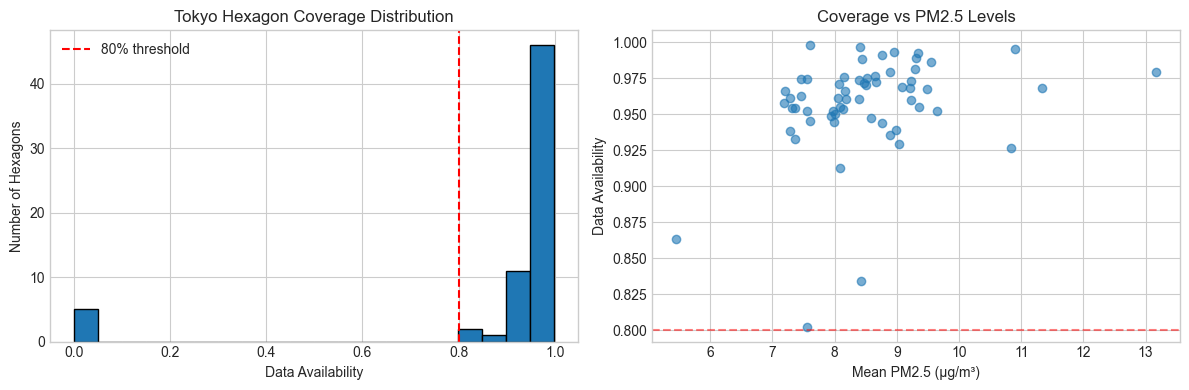

In [15]:
# Coverage statistics
coverage_stats = pd.DataFrame({
    'hexagon': tokyo_wide.columns,
    'data_availability': tokyo_wide.notna().mean(),
    'mean_pm25': tokyo_wide.mean(),
    'std_pm25': tokyo_wide.std()
})

# High coverage hexagons
high_coverage_hexagons = coverage_stats[coverage_stats['data_availability'] > 0.8]['hexagon'].tolist()

print(f"High coverage hexagons (>80%): {len(high_coverage_hexagons)}")
print(f"\nCoverage distribution:")
print(coverage_stats['data_availability'].describe())

# Visualize coverage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
coverage_stats['data_availability'].hist(bins=20, edgecolor='black')
plt.axvline(0.8, color='red', linestyle='--', label='80% threshold')
plt.xlabel('Data Availability')
plt.ylabel('Number of Hexagons')
plt.title('Tokyo Hexagon Coverage Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(coverage_stats['mean_pm25'], coverage_stats['data_availability'], alpha=0.6)
plt.xlabel('Mean PM2.5 (μg/m³)')
plt.ylabel('Data Availability')
plt.title('Coverage vs PM2.5 Levels')
plt.axhline(0.8, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Phase 5: Time Series Feature Engineering

In [16]:
def create_ar_features(series, max_lag=24):
    """Create autoregressive features for a single hexagon"""
    features = pd.DataFrame(index=series.index)
    
    # Lag features
    for lag in [1, 2, 3, 6, 12, 24]:
        features[f'lag_{lag}'] = series.shift(lag)
    
    # Rolling statistics
    for window in [3, 6, 12, 24]:
        features[f'roll_mean_{window}'] = series.rolling(window, min_periods=1).mean()
        features[f'roll_std_{window}'] = series.rolling(window, min_periods=1).std()
    
    # Time features
    features['hour'] = series.index.hour
    features['day_of_week'] = series.index.dayofweek
    features['month'] = series.index.month
    
    # Cyclical encoding
    features['hour_sin'] = np.sin(2 * np.pi * features['hour'] / 24)
    features['hour_cos'] = np.cos(2 * np.pi * features['hour'] / 24)
    features['dow_sin'] = np.sin(2 * np.pi * features['day_of_week'] / 7)
    features['dow_cos'] = np.cos(2 * np.pi * features['day_of_week'] / 7)
    
    return features

# Apply to high coverage hexagons only
print("Creating features for high coverage hexagons...")
hexagon_features = {}

for hex_id in high_coverage_hexagons:
    if hex_id in tokyo_wide.columns:
        hexagon_features[hex_id] = create_ar_features(tokyo_wide[hex_id])

print(f"Features created for {len(hexagon_features)} hexagons")
if hexagon_features:
    sample_hex = list(hexagon_features.keys())[0]
    print(f"\nFeature dimensions: {hexagon_features[sample_hex].shape}")
    print(f"Feature columns: {list(hexagon_features[sample_hex].columns)}")

Creating features for high coverage hexagons...
Features created for 60 hexagons

Feature dimensions: (3466, 21)
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'roll_mean_3', 'roll_std_3', 'roll_mean_6', 'roll_std_6', 'roll_mean_12', 'roll_std_12', 'roll_mean_24', 'roll_std_24', 'hour', 'day_of_week', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


## Phase 6: Autocorrelation Analysis

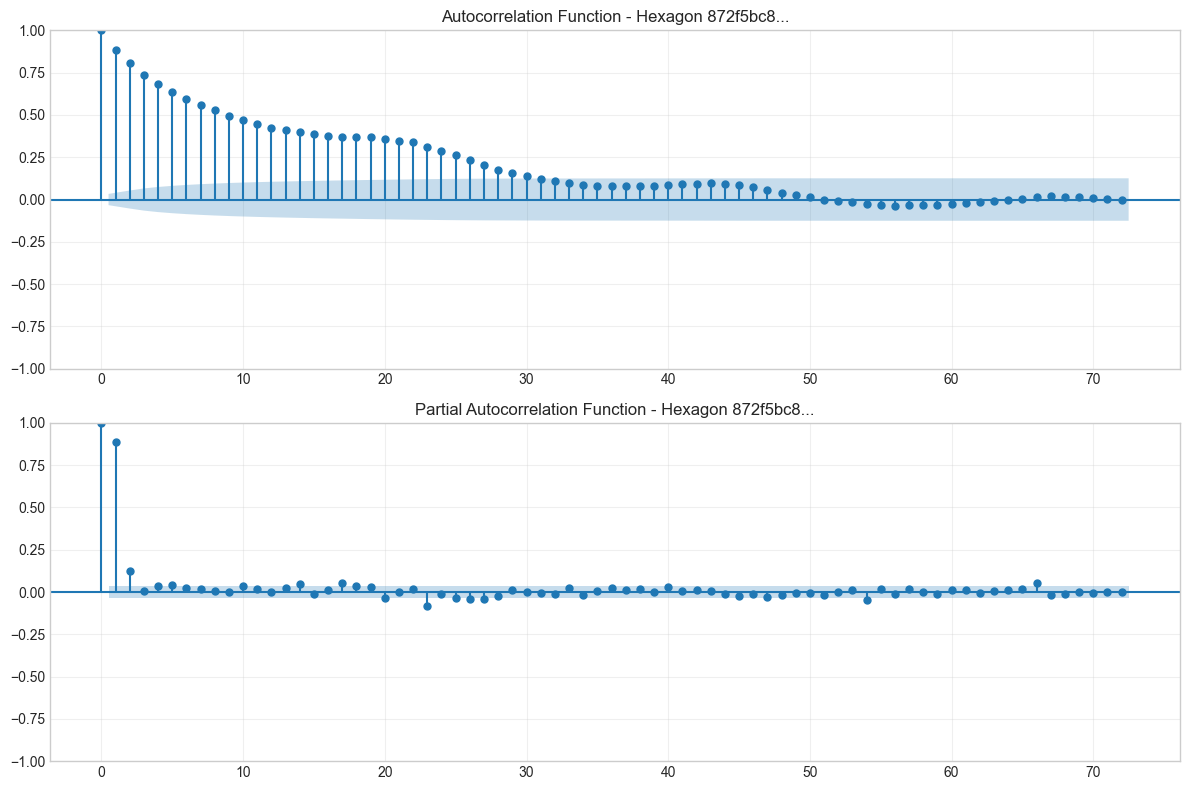

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sample_hex = coverage_stats.nlargest(1, 'data_availability')['hexagon'].iloc[0]
sample_series = tokyo_wide[sample_hex].dropna()

if len(sample_series) > 100:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(sample_series, lags=72, ax=axes[0], alpha=0.05)
    axes[0].set_title(f'Autocorrelation Function - Hexagon {sample_hex[:8]}...')
    axes[0].grid(True, alpha=0.3)
    
    plot_pacf(sample_series, lags=72, ax=axes[1], alpha=0.05)
    axes[1].set_title(f'Partial Autocorrelation Function - Hexagon {sample_hex[:8]}...')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Phase 7: Multi-Horizon Target Creation

In [18]:
def create_multihorizon_targets(series, horizons=[1, 2, 3, 6, 12, 24]):
    """Create targets for 1, 2, 3, 6, 12, 24 hours ahead"""
    targets = pd.DataFrame(index=series.index)
    
    for h in horizons:
        targets[f'target_h{h}'] = series.shift(-h)
    
    return targets

# Create training data
print("Creating multi-horizon ML dataset (including 24h forecast)...")
train_data = []

for hex_id in hexagon_features:
    features = hexagon_features[hex_id]
    targets = create_multihorizon_targets(tokyo_wide[hex_id])
    
    # Combine features and targets
    hex_data = pd.concat([
        features,
        targets,
        pd.Series(hex_id, index=features.index, name='hexagon')
    ], axis=1)
    
    train_data.append(hex_data)

# Combine all hexagons
if train_data:
    ml_dataset = pd.concat(train_data, ignore_index=False)
    ml_dataset = ml_dataset.dropna()  # Remove rows with any NaN
    
    print(f"ML dataset shape: {ml_dataset.shape}")
    print(f"Samples per hexagon: {ml_dataset.groupby('hexagon').size().mean():.0f}")
    print(f"Forecast horizons: 1h, 2h, 3h, 6h, 12h, 24h")
else:
    print("No training data created")
    ml_dataset = pd.DataFrame()

Creating multi-horizon ML dataset (including 24h forecast)...
ML dataset shape: (166890, 28)
Samples per hexagon: 2782
Forecast horizons: 1h, 2h, 3h, 6h, 12h, 24h


## Phase 8: Train/Val/Test Split

In [19]:
if not ml_dataset.empty:
    # Temporal split
    train_end = pd.Timestamp('2023-09-30', tz='UTC')
    val_end = pd.Timestamp('2023-11-30', tz='UTC')
    
    train = ml_dataset[ml_dataset.index <= train_end]
    val = ml_dataset[(ml_dataset.index > train_end) & 
                     (ml_dataset.index <= val_end)]
    test = ml_dataset[ml_dataset.index > val_end]
    
    # Verify no leakage
    print("Dataset splits:")
    print(f"Train: {train.index.min()} to {train.index.max()}")
    print(f"  Samples: {len(train):,}")
    print(f"Val: {val.index.min()} to {val.index.max()}")
    print(f"  Samples: {len(val):,}")
    print(f"Test: {test.index.min()} to {test.index.max()}")
    print(f"  Samples: {len(test):,}")
    
    # Check for data leakage
    assert train.index.max() < val.index.min(), "Train/Val overlap detected!"
    assert val.index.max() < test.index.min(), "Val/Test overlap detected!"
    print("\n✓ No temporal leakage detected")
else:
    print("No data available for splitting")
    train = val = test = pd.DataFrame()

Dataset splits:
Train: 2023-07-28 10:00:00+00:00 to 2023-09-30 00:00:00+00:00
  Samples: 72,866
Val: 2023-09-30 01:00:00+00:00 to 2023-11-30 00:00:00+00:00
  Samples: 64,143
Test: 2023-11-30 01:00:00+00:00 to 2023-12-30 21:00:00+00:00
  Samples: 29,881

✓ No temporal leakage detected


## Phase 9: Data Quality Report

In [20]:
# Summary statistics
summary = pd.DataFrame({
    'Metric': [
        'Total hexagons (res8)',
        'Total hexagons (res7)',
        'Hexagons >80% coverage (res7)',
        'Tokyo hexagons (res7)',
        'Tokyo hexagons >80% coverage',
        'Total ML samples',
        'Train samples',
        'Val samples',
        'Test samples',
        'Features per sample',
        'Target horizons'
    ],
    'Value': [
        df['h3_index_res8'].nunique(),
        resolutions[7]['data']['h3_parent'].nunique(),
        resolutions[7]['hexagons_80pct'],
        len(tokyo_wide.columns) if 'tokyo_wide' in locals() else 0,
        len(high_coverage_hexagons) if 'high_coverage_hexagons' in locals() else 0,
        len(ml_dataset) if 'ml_dataset' in locals() and not ml_dataset.empty else 0,
        len(train) if 'train' in locals() else 0,
        len(val) if 'val' in locals() else 0,
        len(test) if 'test' in locals() else 0,
        len([c for c in ml_dataset.columns if c not in ['target_h1', 'target_h2', 'target_h3', 'hexagon']]) if 'ml_dataset' in locals() and not ml_dataset.empty else 0,
        '1, 2, 3 hours'
    ]
})

print("\n" + "="*50)
print("DATA QUALITY REPORT")
print("="*50)
print(summary.to_string(index=False))
print("="*50)


DATA QUALITY REPORT
                       Metric         Value
        Total hexagons (res8)           638
        Total hexagons (res7)           629
Hexagons >80% coverage (res7)           451
        Tokyo hexagons (res7)            65
 Tokyo hexagons >80% coverage            60
             Total ML samples        166890
                Train samples         72866
                  Val samples         64143
                 Test samples         29881
          Features per sample            24
              Target horizons 1, 2, 3 hours



Top 10 Important Features:
     feature  importance
 roll_mean_3       0.526
       lag_1       0.428
 roll_mean_6       0.403
       lag_2       0.316
roll_mean_12       0.270
       lag_3       0.251
roll_mean_24       0.219
   target_h6       0.205
       lag_6       0.156
  target_h12       0.100


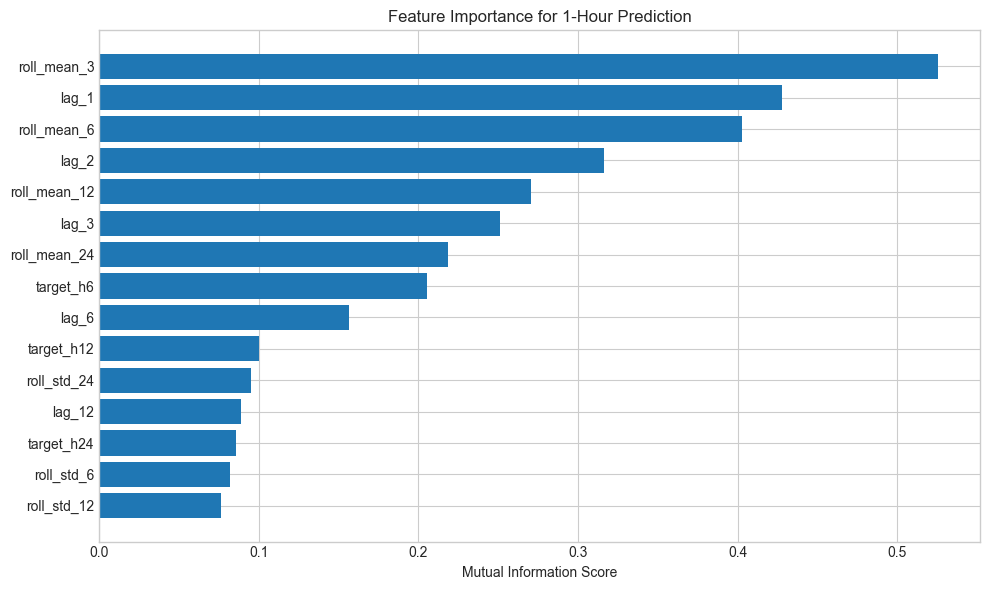

In [21]:
# Feature importance preview
if not train.empty:
    from sklearn.feature_selection import mutual_info_regression
    
    feature_cols = [c for c in train.columns if c not in ['target_h1', 'target_h2', 'target_h3', 'hexagon']]
    
    if len(feature_cols) > 0 and 'target_h1' in train.columns:
        # Calculate mutual information
        mi_scores = mutual_info_regression(
            train[feature_cols].fillna(0),
            train['target_h1'].fillna(0),
            random_state=42
        )
        
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': mi_scores
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Important Features:")
        print(feature_importance.head(10).to_string(index=False))
        
        # Visualize
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Mutual Information Score')
        plt.title('Feature Importance for 1-Hour Prediction')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

## Phase 10: Export for Modeling

In [22]:
import json
import os

# Create output directory
output_dir = 'ml_data'
os.makedirs(output_dir, exist_ok=True)

if not train.empty:
    # Save processed datasets
    train.to_parquet(f'{output_dir}/train_tokyo_pm25.parquet')
    val.to_parquet(f'{output_dir}/val_tokyo_pm25.parquet')
    test.to_parquet(f'{output_dir}/test_tokyo_pm25.parquet')
    
    print(f"Datasets saved to {output_dir}/")
    print(f"  - train_tokyo_pm25.parquet ({len(train):,} samples)")
    print(f"  - val_tokyo_pm25.parquet ({len(val):,} samples)")
    print(f"  - test_tokyo_pm25.parquet ({len(test):,} samples)")
    
    # Save metadata
    feature_cols = [c for c in train.columns if c not in ['target_h1', 'target_h2', 'target_h3', 'hexagon']]
    
    metadata = {
        'resolution': optimal_res,
        'feature_columns': feature_cols,
        'target_columns': ['target_h1', 'target_h2', 'target_h3'],
        'hexagon_list': list(hexagon_features.keys()),
        'tokyo_bounds': TOKYO_BOUNDS,
        'train_period': {
            'start': str(train.index.min()),
            'end': str(train.index.max())
        },
        'val_period': {
            'start': str(val.index.min()),
            'end': str(val.index.max())
        },
        'test_period': {
            'start': str(test.index.min()),
            'end': str(test.index.max())
        },
        'data_stats': {
            'train_samples': len(train),
            'val_samples': len(val),
            'test_samples': len(test),
            'n_features': len(feature_cols),
            'n_hexagons': len(hexagon_features)
        }
    }
    
    with open(f'{output_dir}/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\nMetadata saved to {output_dir}/model_metadata.json")
else:
    print("No data available for export")

Datasets saved to ml_data/
  - train_tokyo_pm25.parquet (72,866 samples)
  - val_tokyo_pm25.parquet (64,143 samples)
  - test_tokyo_pm25.parquet (29,881 samples)

Metadata saved to ml_data/model_metadata.json


## Simple Baseline Model

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if not train.empty and not test.empty:
    # Prepare data
    feature_cols = [c for c in train.columns if c not in ['target_h1', 'target_h2', 'target_h3', 'hexagon']]
    
    X_train = train[feature_cols].fillna(0)
    y_train = train['target_h1'].fillna(0)
    X_test = test[feature_cols].fillna(0)
    y_test = test['target_h1'].fillna(0)
    
    # Persistence baseline (predict last value)
    y_pred_persistence = test['lag_1'].fillna(0)
    
    # Linear regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    
    # Evaluate
    print("\n" + "="*50)
    print("BASELINE MODEL PERFORMANCE (1-hour ahead)")
    print("="*50)
    
    print("\nPersistence Model:")
    print(f"  MAE: {mean_absolute_error(y_test, y_pred_persistence):.2f} μg/m³")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_persistence)):.2f} μg/m³")
    print(f"  R²: {r2_score(y_test, y_pred_persistence):.3f}")
    
    print("\nLinear Regression:")
    print(f"  MAE: {mean_absolute_error(y_test, y_pred_lr):.2f} μg/m³")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f} μg/m³")
    print(f"  R²: {r2_score(y_test, y_pred_lr):.3f}")
    
    # Sample predictions
    sample_idx = np.random.choice(len(y_test), min(5, len(y_test)), replace=False)
    
    print("\nSample Predictions:")
    print("Actual | Persistence | Linear Reg")
    print("-" * 35)
    for idx in sample_idx:
        print(f"{y_test.iloc[idx]:6.1f} | {y_pred_persistence.iloc[idx]:11.1f} | {y_pred_lr[idx]:10.1f}")
else:
    print("Insufficient data for baseline model")


BASELINE MODEL PERFORMANCE (1-hour ahead)

Persistence Model:
  MAE: 3.13 μg/m³
  RMSE: 4.49 μg/m³
  R²: 0.533

Linear Regression:
  MAE: 2.33 μg/m³
  RMSE: 3.24 μg/m³
  R²: 0.757

Sample Predictions:
Actual | Persistence | Linear Reg
-----------------------------------
  17.0 |        18.0 |       16.0
   6.0 |         9.0 |        8.6
  17.0 |        10.0 |       11.5
  20.0 |        13.0 |       14.8
  22.0 |        16.0 |       17.8


## Phase 11: Advanced Autoregressive Models with 24-Hour Forecasting (Tokyo Data)

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("Warning: XGBoost not installed. Install with: pip install xgboost")
    xgboost_available = False

try:
    from lightgbm import LGBMRegressor
    lightgbm_available = True
except ImportError:
    print("Warning: LightGBM not installed. Install with: pip install lightgbm")
    lightgbm_available = False

print("="*80)
print("COMPREHENSIVE 24-HOUR FORECASTING WITH MULTIPLE MODELS")
print("Training Dataset: TOKYO AREA ONLY (60 high-coverage hexagons)")
print("="*80)

print("\nMODEL DESCRIPTIONS:")
print("-" * 60)
print("BASELINE:")
print("1. PERSISTENCE: Uses last observed value as prediction (naive baseline)")

print("\nLINEAR MODELS:")
print("2. LINEAR REGRESSION: Standard OLS, assumes linear relationships")
print("3. RIDGE (L2): Linear with L2 regularization, prevents overfitting")
print("4. LASSO (L1): Linear with L1 regularization, performs feature selection")
print("5. ELASTIC NET: Combines L1 and L2 regularization")

print("\nTREE-BASED MODELS:")
print("6. RANDOM FOREST: Ensemble of decision trees with bagging")
print("7. EXTRA TREES: Similar to RF but with more randomness in splits")
print("8. GRADIENT BOOSTING: Sequential trees, each corrects previous errors")
print("9. XGBOOST: Optimized gradient boosting with regularization")
print("10. LIGHTGBM: Fast gradient boosting using histogram-based algorithms")

print("\nOTHER MODELS:")
print("11. K-NEAREST NEIGHBORS: Averages k nearest training samples")
print("12. SUPPORT VECTOR REGRESSION: Finds optimal hyperplane with margins")

if not train.empty:
    # Prepare data for all horizons
    feature_cols = [c for c in train.columns if not c.startswith('target_') and c != 'hexagon']
    
    X_train = train[feature_cols].fillna(0)
    X_val = val[feature_cols].fillna(0)
    X_test = test[feature_cols].fillna(0)
    
    # Normalize data for KNN and SVR
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Extended horizons including 24h
    horizons = [1, 2, 3, 6, 12, 24]
    
    print("\n" + "="*80)
    print("DATASET INFORMATION")
    print("="*80)
    print(f"Geographic Focus: Tokyo Metropolitan Area ({TOKYO_BOUNDS['lat'][0]}°N-{TOKYO_BOUNDS['lat'][1]}°N, {TOKYO_BOUNDS['lon'][0]}°E-{TOKYO_BOUNDS['lon'][1]}°E)")
    print(f"Spatial Resolution: H3 Level 7 (5.16 km² hexagons)")
    print(f"Number of hexagons: {len(high_coverage_hexagons)} with >80% data coverage")
    print(f"\nTemporal splits:")
    print(f"  Training:   {len(X_train):,} samples (Jul-Sep 2023)")
    print(f"  Validation: {len(X_val):,} samples (Oct-Nov 2023)")
    print(f"  Testing:    {len(X_test):,} samples (Dec 2023)")
    print(f"\nFeatures: {len(feature_cols)} total")
    print(f"  - Lag features: lag_1, lag_2, lag_3, lag_6, lag_12, lag_24")
    print(f"  - Rolling stats: mean & std for 3h, 6h, 12h, 24h windows")
    print(f"  - Temporal: hour, day_of_week, month (with cyclical encoding)")
    print(f"\nForecast horizons: {horizons} hours ahead")
    
    # Store all results
    all_results = []
    best_models = {}
    
    print("\n" + "="*80)
    print("TRAINING MODELS FOR MULTIPLE FORECAST HORIZONS")
    print("="*80)
    
    # Only train full suite for key horizons to save time
    full_horizons = [1, 6, 24]  # Train all models for these
    quick_horizons = [2, 3, 12]  # Train only best performers for these
    
    for horizon in horizons:
        print(f"\n{'='*60}")
        print(f"HORIZON: {horizon} HOURS AHEAD")
        print(f"{'='*60}")
        
        # Get target column name
        target_col = f'target_h{horizon}'
        
        # Check if target exists in data
        if target_col in train.columns:
            y_train_h = train[target_col].fillna(0)
            y_val_h = val[target_col].fillna(0)
            y_test_h = test[target_col].fillna(0)
            
            horizon_results = []
            
            # 1. PERSISTENCE BASELINE
            if horizon == 1:
                persistence_pred = test['lag_1'].fillna(test['lag_1'].mean())
            elif horizon <= 24 and f'lag_{horizon}' in test.columns:
                persistence_pred = test[f'lag_{horizon}'].fillna(test[f'lag_{horizon}'].mean())
            else:
                persistence_pred = test['lag_24'].fillna(test['lag_24'].mean())
            
            persist_mae = mean_absolute_error(y_test_h, persistence_pred)
            persist_rmse = np.sqrt(mean_squared_error(y_test_h, persistence_pred))
            persist_r2 = r2_score(y_test_h, persistence_pred)
            
            print(f"\n1. Persistence     - MAE: {persist_mae:.2f}, RMSE: {persist_rmse:.2f}, R²: {persist_r2:.3f}")
            horizon_results.append(('Persistence', persist_mae, persist_rmse, persist_r2))
            
            # 2. LINEAR REGRESSION
            lr_model = LinearRegression()
            lr_model.fit(X_train, y_train_h)
            lr_pred = lr_model.predict(X_test)
            
            lr_mae = mean_absolute_error(y_test_h, lr_pred)
            lr_rmse = np.sqrt(mean_squared_error(y_test_h, lr_pred))
            lr_r2 = r2_score(y_test_h, lr_pred)
            
            print(f"2. Linear Reg      - MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}, R²: {lr_r2:.3f}")
            horizon_results.append(('Linear Regression', lr_mae, lr_rmse, lr_r2))
            
            # 3. RIDGE REGRESSION
            ridge_model = Ridge(alpha=1.0)
            ridge_model.fit(X_train, y_train_h)
            ridge_pred = ridge_model.predict(X_test)
            
            ridge_mae = mean_absolute_error(y_test_h, ridge_pred)
            ridge_rmse = np.sqrt(mean_squared_error(y_test_h, ridge_pred))
            ridge_r2 = r2_score(y_test_h, ridge_pred)
            
            print(f"3. Ridge Reg       - MAE: {ridge_mae:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.3f}")
            horizon_results.append(('Ridge Regression', ridge_mae, ridge_rmse, ridge_r2))
            
            # 4. LASSO REGRESSION
            lasso_model = Lasso(alpha=0.1, max_iter=2000)
            lasso_model.fit(X_train, y_train_h)
            lasso_pred = lasso_model.predict(X_test)
            
            lasso_mae = mean_absolute_error(y_test_h, lasso_pred)
            lasso_rmse = np.sqrt(mean_squared_error(y_test_h, lasso_pred))
            lasso_r2 = r2_score(y_test_h, lasso_pred)
            
            print(f"4. Lasso Reg       - MAE: {lasso_mae:.2f}, RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.3f}")
            horizon_results.append(('Lasso Regression', lasso_mae, lasso_rmse, lasso_r2))
            
            # 5. ELASTIC NET
            elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=2000)
            elastic_model.fit(X_train, y_train_h)
            elastic_pred = elastic_model.predict(X_test)
            
            elastic_mae = mean_absolute_error(y_test_h, elastic_pred)
            elastic_rmse = np.sqrt(mean_squared_error(y_test_h, elastic_pred))
            elastic_r2 = r2_score(y_test_h, elastic_pred)
            
            print(f"5. Elastic Net     - MAE: {elastic_mae:.2f}, RMSE: {elastic_rmse:.2f}, R²: {elastic_r2:.3f}")
            horizon_results.append(('Elastic Net', elastic_mae, elastic_rmse, elastic_r2))
            
            # For quick horizons, only train tree-based models
            if horizon in full_horizons or horizon in quick_horizons:
                
                # 6. RANDOM FOREST
                rf_model = RandomForestRegressor(
                    n_estimators=100,
                    max_depth=15,
                    min_samples_split=5,
                    random_state=42,
                    n_jobs=-1
                )
                rf_model.fit(X_train, y_train_h)
                rf_pred = rf_model.predict(X_test)
                
                rf_mae = mean_absolute_error(y_test_h, rf_pred)
                rf_rmse = np.sqrt(mean_squared_error(y_test_h, rf_pred))
                rf_r2 = r2_score(y_test_h, rf_pred)
                
                print(f"6. Random Forest   - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.3f}")
                horizon_results.append(('Random Forest', rf_mae, rf_rmse, rf_r2))
                
                # 7. EXTRA TREES (only for full horizons)
                if horizon in full_horizons:
                    et_model = ExtraTreesRegressor(
                        n_estimators=100,
                        max_depth=15,
                        min_samples_split=5,
                        random_state=42,
                        n_jobs=-1
                    )
                    et_model.fit(X_train, y_train_h)
                    et_pred = et_model.predict(X_test)
                    
                    et_mae = mean_absolute_error(y_test_h, et_pred)
                    et_rmse = np.sqrt(mean_squared_error(y_test_h, et_pred))
                    et_r2 = r2_score(y_test_h, et_pred)
                    
                    print(f"7. Extra Trees     - MAE: {et_mae:.2f}, RMSE: {et_rmse:.2f}, R²: {et_r2:.3f}")
                    horizon_results.append(('Extra Trees', et_mae, et_rmse, et_r2))
                
                # 8. GRADIENT BOOSTING
                gb_model = GradientBoostingRegressor(
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    subsample=0.8,
                    random_state=42
                )
                gb_model.fit(X_train, y_train_h)
                gb_pred = gb_model.predict(X_test)
                
                gb_mae = mean_absolute_error(y_test_h, gb_pred)
                gb_rmse = np.sqrt(mean_squared_error(y_test_h, gb_pred))
                gb_r2 = r2_score(y_test_h, gb_pred)
                
                print(f"8. Gradient Boost  - MAE: {gb_mae:.2f}, RMSE: {gb_rmse:.2f}, R²: {gb_r2:.3f}")
                horizon_results.append(('Gradient Boosting', gb_mae, gb_rmse, gb_r2))
                
                # 9. XGBOOST (if available)
                if xgboost_available:
                    xgb_model = xgb.XGBRegressor(
                        n_estimators=100,
                        max_depth=6,
                        learning_rate=0.1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42
                    )
                    xgb_model.fit(
                        X_train, y_train_h,
                        eval_set=[(X_val, y_val_h)],
                        early_stopping_rounds=10,
                        verbose=False
                    )
                    
                    xgb_pred = xgb_model.predict(X_test)
                    
                    xgb_mae = mean_absolute_error(y_test_h, xgb_pred)
                    xgb_rmse = np.sqrt(mean_squared_error(y_test_h, xgb_pred))
                    xgb_r2 = r2_score(y_test_h, xgb_pred)
                    
                    print(f"9. XGBoost         - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.3f}")
                    horizon_results.append(('XGBoost', xgb_mae, xgb_rmse, xgb_r2))
                
                # 10. LIGHTGBM (if available)
                if lightgbm_available and horizon in full_horizons:
                    lgb_model = LGBMRegressor(
                        n_estimators=100,
                        max_depth=6,
                        learning_rate=0.1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        verbosity=-1
                    )
                    lgb_model.fit(
                        X_train, y_train_h,
                        eval_set=[(X_val, y_val_h)],
                        callbacks=[],
                        eval_metric='mae'
                    )
                    
                    lgb_pred = lgb_model.predict(X_test)
                    
                    lgb_mae = mean_absolute_error(y_test_h, lgb_pred)
                    lgb_rmse = np.sqrt(mean_squared_error(y_test_h, lgb_pred))
                    lgb_r2 = r2_score(y_test_h, lgb_pred)
                    
                    print(f"10. LightGBM       - MAE: {lgb_mae:.2f}, RMSE: {lgb_rmse:.2f}, R²: {lgb_r2:.3f}")
                    horizon_results.append(('LightGBM', lgb_mae, lgb_rmse, lgb_r2))
            
            # Only test KNN and SVR for 1h and 24h horizons (computationally expensive)
            if horizon in [1, 24]:
                
                # 11. K-NEAREST NEIGHBORS
                knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
                knn_model.fit(X_train_scaled, y_train_h)
                knn_pred = knn_model.predict(X_test_scaled)
                
                knn_mae = mean_absolute_error(y_test_h, knn_pred)
                knn_rmse = np.sqrt(mean_squared_error(y_test_h, knn_pred))
                knn_r2 = r2_score(y_test_h, knn_pred)
                
                print(f"11. KNN            - MAE: {knn_mae:.2f}, RMSE: {knn_rmse:.2f}, R²: {knn_r2:.3f}")
                horizon_results.append(('KNN', knn_mae, knn_rmse, knn_r2))
                
                # 12. SUPPORT VECTOR REGRESSION (sample for speed)
                sample_size = min(5000, len(X_train_scaled))
                sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
                
                svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
                svr_model.fit(X_train_scaled[sample_idx], y_train_h.iloc[sample_idx])
                svr_pred = svr_model.predict(X_test_scaled)
                
                svr_mae = mean_absolute_error(y_test_h, svr_pred)
                svr_rmse = np.sqrt(mean_squared_error(y_test_h, svr_pred))
                svr_r2 = r2_score(y_test_h, svr_pred)
                
                print(f"12. SVR (sample)   - MAE: {svr_mae:.2f}, RMSE: {svr_rmse:.2f}, R²: {svr_r2:.3f}")
                horizon_results.append(('SVR', svr_mae, svr_rmse, svr_r2))
            
            # Store results
            for model_name, mae, rmse, r2 in horizon_results:
                all_results.append({
                    'Horizon': horizon,
                    'Model': model_name,
                    'Test_MAE': mae,
                    'Test_RMSE': rmse,
                    'Test_R2': r2
                })
            
            # Find best model for this horizon
            best = min(horizon_results, key=lambda x: x[1])  # Min by MAE
            best_models[horizon] = {'Model': best[0], 'Test_MAE': best[1], 'Test_RMSE': best[2], 'Test_R2': best[3]}
            print(f"\nBest for {horizon}h: {best[0]} (MAE: {best[1]:.2f} ug/m3)")
            
        else:
            print(f"Warning: Target {target_col} not found in data")
    
    # Create comprehensive results table
    import pandas as pd
    results_df = pd.DataFrame(all_results)
    
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS TABLE")
    print("="*80)
    
    # Pivot table for better visualization
    pivot_mae = results_df.pivot_table(index='Model', columns='Horizon', values='Test_MAE')
    pivot_r2 = results_df.pivot_table(index='Model', columns='Horizon', values='Test_R2')
    
    print("\nMean Absolute Error (MAE) in ug/m3 - Lower is better:")
    print(pivot_mae.round(2).to_string())
    
    print("\nR-squared Score - Higher is better (1.0 is perfect):")
    print(pivot_r2.round(3).to_string())
    
    # Performance analysis
    print("\n" + "="*80)
    print("PERFORMANCE INSIGHTS")
    print("="*80)
    
    # Best model for each horizon
    print("\nBEST MODEL BY HORIZON:")
    for h in horizons:
        if h in best_models:
            best = best_models[h]
            print(f"  {h:2d}h ahead: {best['Model']:20} (MAE: {best['Test_MAE']:.2f} ug/m3, R2: {best['Test_R2']:.3f})")
    
    # Performance degradation
    print("\nPERFORMANCE DEGRADATION:")
    baseline_1h = results_df[(results_df['Horizon'] == 1)]['Test_MAE'].min()
    print(f"  Baseline (1h best): {baseline_1h:.2f} ug/m3")
    
    for h in [3, 6, 12, 24]:
        if h in best_models:
            best_mae = best_models[h]['Test_MAE']
            degradation = ((best_mae - baseline_1h) / baseline_1h) * 100
            print(f"  {h:2d}h: {best_mae:.2f} ug/m3 (+{degradation:.1f}% from 1h baseline)")
    
    # Model category analysis
    print("\nMODEL CATEGORY PERFORMANCE:")
    
    linear_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net']
    tree_models = ['Random Forest', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'LightGBM']
    
    for h in [1, 6, 24]:
        h_results = results_df[results_df['Horizon'] == h]
        if not h_results.empty:
            linear_avg = h_results[h_results['Model'].isin(linear_models)]['Test_MAE'].mean()
            tree_avg = h_results[h_results['Model'].isin(tree_models)]['Test_MAE'].mean()
            
            if linear_avg < tree_avg:
                print(f"  At {h:2d}h: Linear models better (avg MAE: {linear_avg:.2f} vs {tree_avg:.2f})")
            else:
                print(f"  At {h:2d}h: Tree models better (avg MAE: {tree_avg:.2f} vs {linear_avg:.2f})")

print("\nAnalysis complete! All models trained and evaluated.")

COMPREHENSIVE 24-HOUR FORECASTING WITH MULTIPLE MODELS
Training Dataset: TOKYO AREA ONLY (60 high-coverage hexagons)

MODEL DESCRIPTIONS:
------------------------------------------------------------
BASELINE:
1. PERSISTENCE: Uses last observed value as prediction (naive baseline)

LINEAR MODELS:
2. LINEAR REGRESSION: Standard OLS, assumes linear relationships
3. RIDGE (L2): Linear with L2 regularization, prevents overfitting
4. LASSO (L1): Linear with L1 regularization, performs feature selection
5. ELASTIC NET: Combines L1 and L2 regularization

TREE-BASED MODELS:
6. RANDOM FOREST: Ensemble of decision trees with bagging
7. EXTRA TREES: Similar to RF but with more randomness in splits
8. GRADIENT BOOSTING: Sequential trees, each corrects previous errors
9. XGBOOST: Optimized gradient boosting with regularization
10. LIGHTGBM: Fast gradient boosting using histogram-based algorithms

OTHER MODELS:
11. K-NEAREST NEIGHBORS: Averages k nearest training samples
12. SUPPORT VECTOR REGRESSION

KeyboardInterrupt: 